Derived from reading through ["What is `torch.nn` _really_?"](https://pytorch.org/tutorials/beginner/nn_tutorial.html).
* I find this generally ironic, because Jeremy likes to teach from a high-level
* This tutorial is going to be everything from the bottom-up

---

In [3]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

In [4]:
URL = "http://deeplearning.net/data/mnist/"

In [5]:
def make_filestructure(filename):
    if not (PATH / filename).exists():
        content = requests.get(URL + filename).content
        (PATH / filename).open("wb").write(content)

In [6]:
def load_train_validation_sets(filename):
    import pickle
    import gzip
    
    with gzip.open((PATH / filename).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
        return ((x_train, y_train), (x_valid, y_valid))

Now let's actually bring in the data

In [7]:
FILENAME = "mnist.pkl.gz"

make_filestructure(FILENAME)

Just a sidenote - this is __totally__ how Jeremy Howard codes:
1. Very brief, but super-effective, blocks of code
2. No comments, but the code is so _direct_ that the given assumption that you can code in Python is all you need

In [8]:
xy_train, xy_valid = load_train_validation_sets(FILENAME)

In [11]:
def show_one_digit(images_flat):
    from matplotlib import pyplot
    import numpy as np
    
    random_index = np.random.randint(len(images_flat), size=1)[0]
    # show our random image in grayscale
    pyplot.imshow(images_flat[random_index].reshape((28, 28)), cmap="gray")
    print("images.shape =", images_flat.shape)

images.shape = (50000, 784)


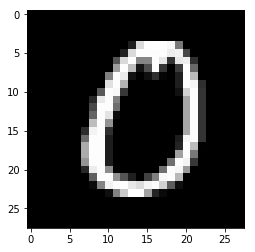

In [15]:
# pass in the training set, but it doesn't really matter which one we look at
show_one_digit(xy_train[0])